![HSV-AI Logo](https://hsv.ai/wp-content/uploads/2022/03/logo_v11_2022.png)

# Implicit Recommendation from Bakery Data

The dataset used for this work is from Kaggle [Transactions from a bakery](https://www.kaggle.com/datasets/sulmansarwar/transactions-from-a-bakery):

## Basics of EDA

Here are a few things that we are looking for in the invoice / transaction data:

1. Were there any negative totals? If so why?
2. What percentage of the purchases actually contained multiple items?
3. What is the spread of purchases by customer ID? Do we have a few customers whose behavior may drive recommendations in a way that doesn't fit the average customer?
4. Where there any purchases that were VERY large? If so why? Do we want to include these values to train model behavior?
5. Is there any missing data that we need to scrub?


In [1]:
%reload_kedro

2022-04-16 14:02:39,974 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-04-16 14:02:40,001 - kedro.config.config - INFO - Config from path `/home/jlangley/git/product-recommendation/conf/bakery` will override the following existing top-level config keys: alpha, factors, filter_value, iterations, maximum_order_size, minimum_order_size, regularization, seed, test_size, wandb_project
2022-04-16 14:02:40,002 - root - INFO - ** Kedro project productrec
2022-04-16 14:02:40,004 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-04-16 14:02:40,014 - root - INFO - Registered line magic `run_viz`


/home/jlangley/miniconda3/envs/product/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/home/jlangley/git/product-recommendation/conf/base', '/home/jlangley/git/product-recommendation/conf/bakery'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [2]:
import pandas as pd
import numpy as np
import random
import scipy.sparse
from matplotlib import pyplot as plt
from pandas.api.types import CategoricalDtype


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [3]:
transactions = catalog.load("bakery_kaggle_order_data")

transactions.head()
transactions['NumberOfItemsPurchased'] = 1
transactions['Customer'] = 'none'
transactions['Description'] = 'none'
transactions["Price"] = 0.0

2022-04-16 14:02:40,335 - kedro.io.data_catalog - INFO - Loading data from `bakery_kaggle_order_data` (CSVDataSet)...


# Checking for missing data

In [4]:
print('Total length is',len(transactions))
transactions.isna().sum()

Total length is 21293


Date                      0
Time                      0
Transaction               0
Item                      0
NumberOfItemsPurchased    0
Customer                  0
Description               0
Price                     0
dtype: int64

In [5]:
transactions.describe()

,Transaction,NumberOfItemsPurchased,Price
count,21293.000000,21293.0,21293.0
mean,4951.990889,1.0,0.0
std,2787.758400,0.0,0.0
min,1.000000,1.0,0.0
25%,2548.000000,1.0,0.0
50%,5067.000000,1.0,0.0
75%,7329.000000,1.0,0.0
max,9684.000000,1.0,0.0


There are 95  transactions

Here are the product counts of transactions ordered from largest to smallest
[5471 3325 1435 1025  856  786  771  616  590  540  379  374  370  369
  369  342  327  318  277  193  185  172  159  152  149  146  136  125
  123  107   99   81   77   63   58   54   54   48   47   44   38   38
   28   28   21   18   17   16   14   13   13   12   12   12   11   11
   11   10   10    9    8    8    8    7    7    7    7    6    6    6
    6    6    6    5    5    5    4    3    3    3    3    2    2    2
    2    2    2    1    1    1    1    1    1    1    1]

And a graph of what the curve looks like:


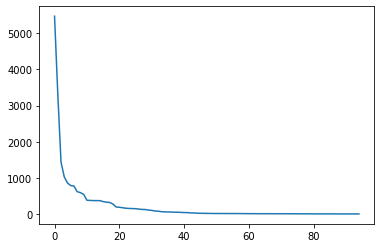

In [6]:
transaction_counts = transactions['Item'].value_counts().to_numpy()
print('There are', len(transaction_counts), ' transactions\n')
print('Here are the product counts of transactions ordered from largest to smallest')
print(transaction_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(transaction_counts) 
plt.show()

# Transactions over Time

Now we need to look at the number of items purchased each day to see if there is anything interesting that pops out.

In [7]:
from datetime import datetime

datetime_object = datetime.strptime('2016-10-30 09:58:11', '%Y-%m-%d %H:%M:%S')

        
# Mon Feb 12 04:26:00 IST 2018
def func(date, time):
    strdate = "{} {}".format(date, time)
    temp = datetime.strptime(strdate, '%Y-%m-%d %H:%M:%S')
    return temp.strftime('%Y%m%d')

transactions['datetime'] = transactions.apply(lambda x: func(x.Date, x.Time), axis=1)


<AxesSubplot:>

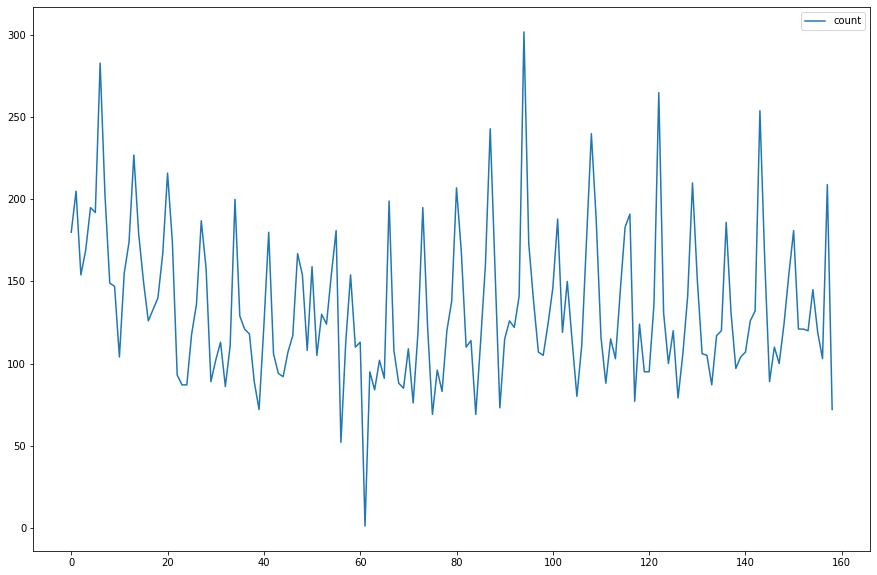

In [8]:
transactions.groupby(['datetime'])['datetime'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['datetime'], ascending=True) \
                             .plot(figsize=(15,10))

# Data Sparcity

Let's take a look at the sparcity of the data. This will tell us how many products were purchased across multiple orders. This is directly related to how well a recommendation system can be trained.

In [9]:
transaction_list = list(np.sort(transactions.Transaction.unique())) # Get our unique customers
item_list = list(transactions.Item.unique()) # Get our unique products that were purchased
quantity_list = list(transactions.NumberOfItemsPurchased) # All of our purchases

cols = transactions.Transaction.astype(CategoricalDtype(categories=transaction_list, ordered=True)).cat.codes 
# Get the associated row indices
rows = transactions.Item.astype(CategoricalDtype(categories=item_list, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity_list, (rows, cols)), shape=(len(item_list), len(transaction_list)))

In [10]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

97.83090082776977

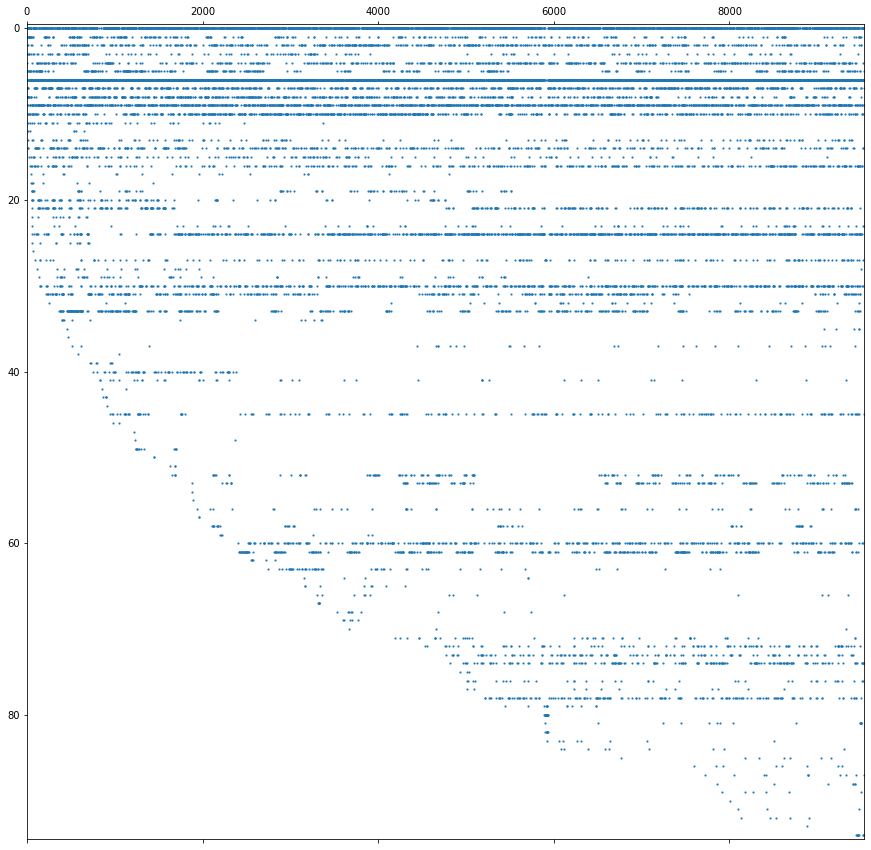

In [11]:
plt.figure(figsize=(15, 15))
plt.spy(purchases_sparse, markersize=1, aspect='auto')

# Storing Interim Data

Now that we have the data cleaned up a bit and formatted correctly, we can save it to an interim file to be picked up by the model training algorithm.

In [12]:
renamed_df = transactions.rename(columns={"Transaction": "order_id", 
                        "Item": "product_id",
                        "Customer": "customer_id",
                        "Description":"description",
                        "NumberOfItemsPurchased":"quantity",
                        "Price":"price"})[['order_id', 'product_id', 'customer_id', 'description', 'quantity', 'price']]


catalog.save("transactions", renamed_df)


2022-04-16 14:02:41,866 - kedro.io.data_catalog - INFO - Saving data to `transactions` (CSVDataSet)...
